In [65]:
import numpy as np
import matplotlib.pyplot as plt
import os
from random import randrange, uniform
import PIL
plt.rcParams["figure.figsize"] = (20,10)

### Majority

Nuestro problema consiste en simular una grilla de valores binarios con una dinamica muy simple. En cada paso una celda cambia de estado segun la mayoria de sus vecinos. A esto le agregamos un poco de dinamica extra
- El delay que en la aplicacion de la regla es aleatorio
- La regla solo se aplica probabilisticamente

Nos planteamos algunas preguntas como:
- ¿Bajo que condiciones iniciales llegamos a un estado comun entre todas las celdas?
- ¿Como se comporta el sistema para ciertas configuraciones iniciales?
- ¿Como afecta el ratio de la aplicacion de la regla a el tiempo de convergencia?


Para correr las cosas ahi que configurar el path de esta carpeta y de el bin de CD++

<span style="color:red">SOLO CAMBIAR LOS PATHS!</span>.

In [2]:
from pathlib import Path

SED_HOME = Path.home().joinpath('Documents').joinpath('sed')

#Directorio base donde está instalado el siumulador
CDPP_DIR = SED_HOME.joinpath('CDPP')

CDPP_SRC = CDPP_DIR.joinpath('src')
CDPP_EXAMPLES = CDPP_DIR.joinpath('examples')
CDPP_SCRIPTS = CDPP_DIR.joinpath('scripts')
BASE_BIN = CDPP_SRC.joinpath('bin')
CDPP_ATOMICS = CDPP_SRC.joinpath('cd++/atomics')

CDPP_EXAMPLES_CELL = CDPP_EXAMPLES.joinpath('cell-devs')
CDPP_BIN = BASE_BIN.joinpath('cd++')
DRAWLOG_BIN = BASE_BIN.joinpath('drawlog')

majority_folder = str(CDPP_EXAMPLES)+"/dc-sed-tp2-2022"
majority_folder

'/home/seduser/Documents/sed/CDPP/examples/dc-sed-tp2-2022'

In [3]:
majority_folder = "/home/seduser/SED/tp2"

In [5]:
BASE_BIN = "/home/seduser/SED/CDPP_ExtendedStates-codename-Santi/src/bin"

In [6]:
def run_majority():
    command = str(BASE_BIN) + "/cd++ -m majority.ma -l logs/majority.log -t 00:32:00:000"
    os.system(command)  

In [7]:
def time_to_secs(time):
    h, m, s, ms, r = time.split(':')
    return float(h)*60*60. + float(m)*60. + float(s) + float(ms)/1000. + float(r)/1000.

In [8]:
def numpy_arrays_from_log(rows, columns):
    log_path= majority_folder + "/logs/majority.log01"
    with open(log_path) as f:
        lines = f.readlines()
    lines = list(filter(lambda x : "out" in x, lines))
    times = list(map(lambda x : time_to_secs((x.split("/")[3])), lines))
    values = list(map(lambda x : float((x.split("/")[6]).strip()), lines))
    positions = list(map(lambda x : (x.split("/")[4].split("(")[1].split(")")[0]).split(","), lines))
    positions = list(map(lambda x : (int(x[0]), int(x[1]) ), positions) )

    current_values = np.array(values[:rows*columns]).reshape((rows, columns))
    current_t = times[0]
    grids = []
    for t, v, pos in zip(times,values,positions):
        if current_t != t:
            current_t = t
            grids.append(np.copy(current_values))
        i, j = pos
        current_values[i][j] = v
    grids.append(current_values)

    return grids

In [9]:
def get_global_vote_series(grids):
    return [np.mean(x) for x in grids]

In [10]:
def set_model_grid_size(rows, columns):
    ma_path= majority_folder + "/majority.ma"

    with open(ma_path, 'r') as file:
        lines = file.readlines()
    dim_ind = filter( lambda x: "dim : " in x[1], enumerate(lines))
    dim_ind = next(map(lambda x: x[0], dim_ind))
    lines[dim_ind] = "dim : (" + str(rows) + "," + str(columns) + ")\n"
    with open(ma_path, 'w') as file:
        file.writelines( lines )

In [11]:
def initial_val_generator(rows, columns, p=0.5):
    val_path= majority_folder + "/majority.val"
    lines = []
    for i in range(rows):
        for j in range(columns):
            pos = "(" + str(i) + "," + str(j) + ") = "
            val =  int(uniform(0,1) > p)
            lines.append(pos + str(val) + "\n")

            # lines.append(pos + "[" + str(val) + ",0]" + "\n")

    with open(val_path, 'w') as file:
        file.writelines( lines )

In [12]:
def line_val_generator(rows, columns, p=0.9):
    val_path= majority_folder + "/majority.val"
    lines = []
    last_val = 1
    for i in range(rows):
        for j in range(columns):
            pos = "(" + str(i) + "," + str(j) + ") = "
            val =  last_val if uniform(0,1) > p else abs(1-last_val)
            lines.append(pos + str(val) + "\n")

    with open(val_path, 'w') as file:
        file.writelines( lines )

In [15]:
from PIL import Image

def create_collage(width, height, listofimages, times, max_size):
    all_white = (255, 255, 255)
    new_im = Image.new('RGB', (width, height), all_white)
    ims = []
    for p in listofimages:
        im = Image.open(p)
        new_size = int(uniform(5,max_size))
        im = im.resize((new_size, new_size))
        ims.append(im)
    for i in range(times):
        img_random = int(uniform(0,len(ims)))
        x_random = int(uniform(0,width))
        y_random = int(uniform(0,width))
        new_im.paste(ims[img_random], (x_random, y_random))

    new_im.save("images/collage.png")
    
create_collage(60, 60, ['images/circle.png','images/star.png', 'images/square.png'], 10, 30)

In [16]:
def get_clusters(grid):
    rows, columns = grid.shape[0], grid.shape[1]
    not_seen = set()
    for i in range(rows):
        for j in range(columns):
            not_seen.add((i,j))
            
    
    clusters = []
    n_clusters = 0
    
    while len(not_seen) > 0:
        current_cluster = set()
        i, j = not_seen.pop()
        current_color = grid[i][j]
        visited = set()
        to_search = {(i,j)}
        
        while len(to_search) > 0:
            i, j = to_search.pop()
            
            if (i,j) in visited:
                continue
            
            visited.add((i,j))
            
            if current_color == grid[i][j]:
                current_cluster.add((i,j))
                
                for di, dj in [(-1,-1),(1,-1),(-1,1),(1,1)]:
                    to_search.add(((i+di)%rows, (j+dj)%columns))
                    
        clusters.append(current_cluster)
        n_clusters += 1
        not_seen = not_seen - current_cluster
        

    return n_clusters

In [25]:
def from_image(path, resize=(40,40)):
    im = (PIL.Image.open(path))
    im = im.resize(resize)
    im = np.asarray(im)
    im = np.mean(im,axis=2)
    im = im >124 # ligeramente mas bajo para que se vea mejor
    #im = im > np.mean(im)
    return im

def grid_to_val(grid):
    val_path= majority_folder + "/majority.val"
    lines = []
    rows = grid.shape[0]
    columns = grid.shape[1]
    for i in range(rows):
        for j in range(columns):
            pos = "(" + str(i) + "," + str(j) + ") = "
            val =  grid[i][j] * 1.0
            lines.append(pos + str(val) + "\n")

    with open(val_path, 'w') as file:
        file.writelines( lines )
        
def img_to_val(path, resize=(40,40)):
    grid_to_val(from_image(path, resize=resize))

### Configuraciones aleatorias

Probamos primero usando configuraciones inicales aleatorias donde cada celda es independiente. Es decir, al momento de construir la grilla inicial seteamos a 1 con probabilidad $p$ y a 0 con probabilidad $1-p$. Para estos experimentos dejamos fijo la probabilidad de aplicar la regla en 70% y el delay de aplicar las reglas en una uniforme entre 100 y 200

Una corrida con $p=0.5$

In [73]:
rows = 40
colums = 40

In [75]:
set_model_grid_size(rows,columns)
initial_val_generator(rows, columns)
run_majority()

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from majority.ma
Loading events from 
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: logs/majority.log
Output to: /dev/null
Tolerance set to: 1e-08
Configuration to show real numbers: Width = 12 - Precision

At 00:00:01:070:000:00:00:148:000:00:00:252:000:00:00:337:000:00:00:462:000:00:00:508:000:00:00:589:000:00:00:626:000:00:00:679:000:00:00:791:000:00:00:910:0

Simulation complete!
Simulation ended!
LP 0 has finished simulation 


In [76]:
grids = numpy_arrays_from_log(rows,columns)


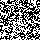

In [77]:
import base64
from IPython.core.display import HTML

imgs = [PIL.Image.fromarray(arr*255) for arr in grids]
imgs[0].save(fp="images/run.gif",format="GIF", append_images=imgs,  duration=37, save_all=True, loop=0)

b64 = base64.b64encode(open("images/run.gif",'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" width=350, height=350 />'))

Podemos ver que el porcentaje de cada clase cambia muy poco/lentamente. Al final de la simulacion se ve un aumento del 3%. Sin embargo el numero de clusters disminuye fuertemente

Text(0, 0.5, 'fraccion de 1s')

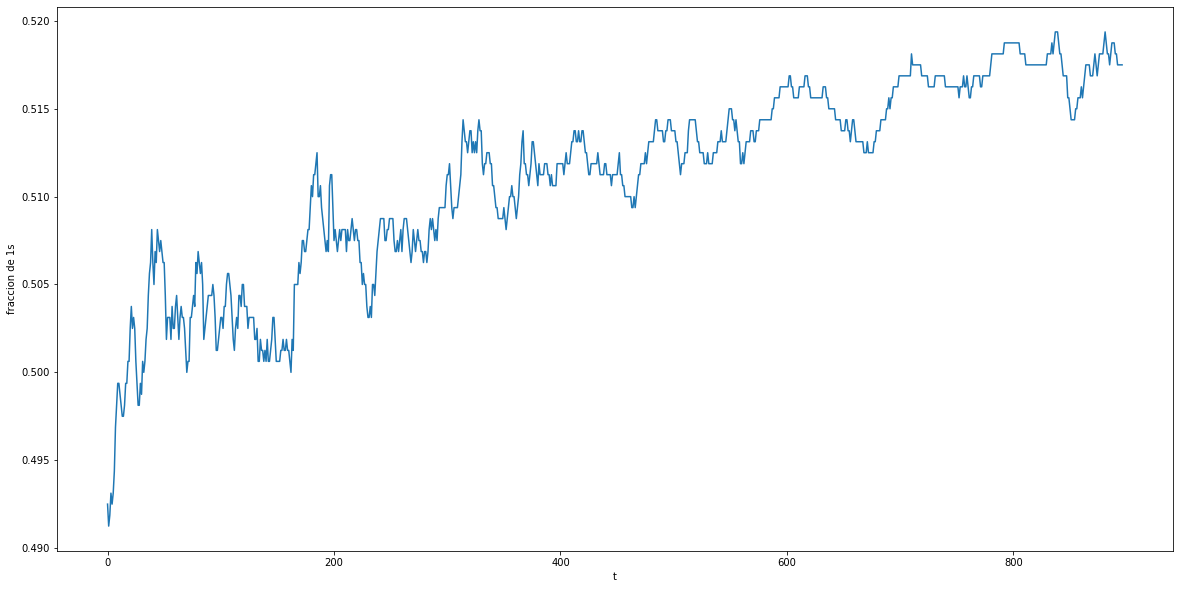

In [79]:
plt.plot(get_global_vote_series(grids))
plt.xlabel("t")
plt.ylabel("fraccion de 1s")


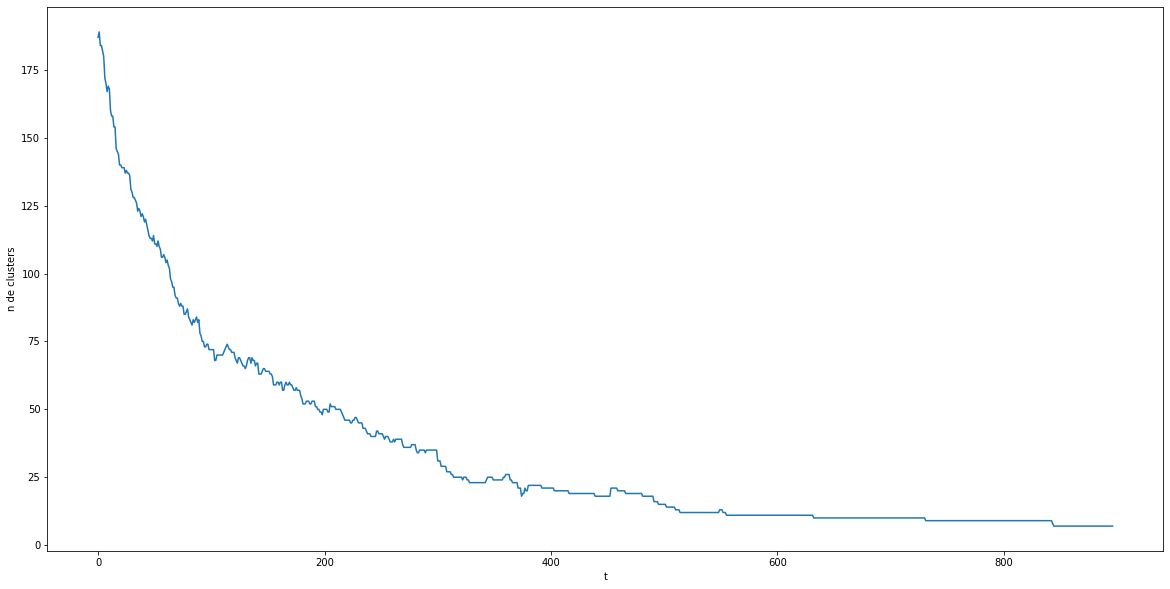

In [80]:
clusters =  [ get_clusters(grids[x]) for x in range(len(grids)) ] 
plt.xlabel("t")
plt.ylabel("n de clusters")
plt.plot(clusters)

Mas general, podemos ver como se comporta con distintos $p$. Vemos que ya con un pequeño desbalance se llega a un punto estable mucho mas rapido y una diferencia mas marcada. En el caso de 60% de 1s incialmente se llega a alrededor del 90%. 

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from majority.ma
Loading events from 
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: logs/majority.log
Output to: /dev/null
Tolerance set to: 1e-08
Configuration to show real numbers: Width = 12 - Precision

Simulation complete!
Simulation ended!
LP 0 has finished simulation 
PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from majority.ma
Loading events from 
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: logs/majority.log
Output to: /dev/null
Tolerance set

Simulation complete!
Simulation ended!
LP 0 has finished simulation 
PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from majority.ma
Loading events from 
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: logs/majority.log
Output to: /dev/null
Tolerance set

Simulation complete!
Simulation ended!
LP 0 has finished simulation 


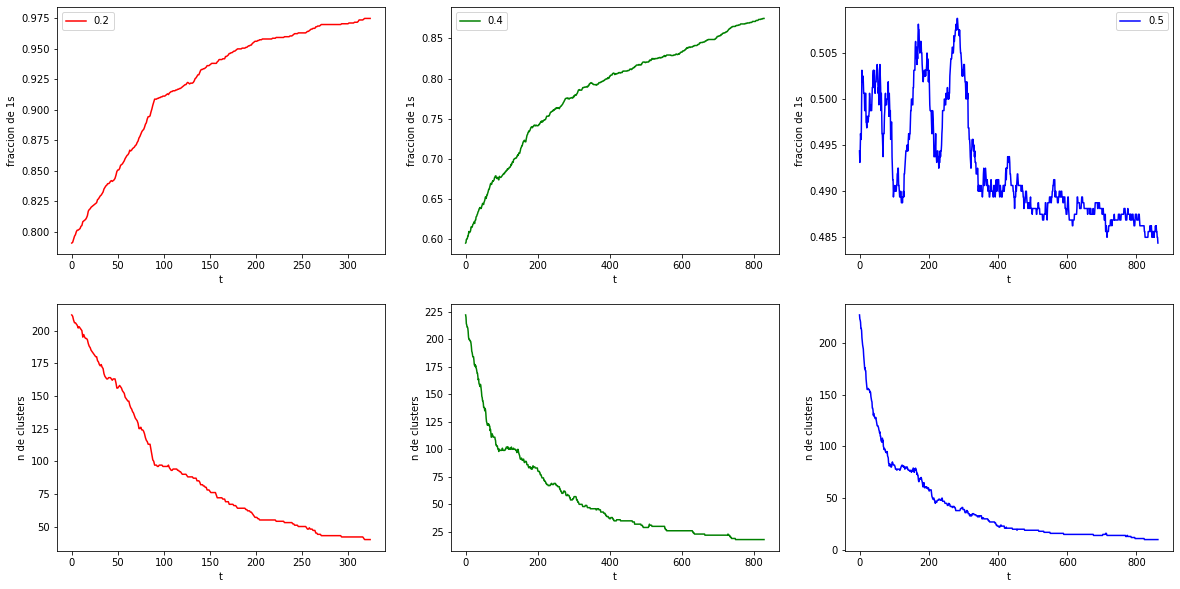

In [91]:
ps = [0.2, 0.4, 0.5]
colors = ["red", "green", "blue"]
fig, axs = plt.subplots(2, len(ps))

for i, x in enumerate(zip(ps, colors)):
    p, c = x
    initial_val_generator(rows,columns, p)
    run_majority()
    grids = numpy_arrays_from_log(rows,columns)
    axs[0][i].plot(get_global_vote_series(grids), label=str(p), color=c)
    axs[0][i].legend()
    axs[0][i].set_xlabel("t")
    axs[0][i].set_ylabel("fraccion de 1s")
    
    clusters =  [ get_clusters(grids[x]) for x in range(len(grids)) ] 
    axs[1][i].set_xlabel("t")
    axs[1][i].set_ylabel("n de clusters")
    axs[1][i].plot(clusters, label=str(p), color=c)

Tambien nos parecio interesante comparar el ritmo de reduccion de clusters en un solo grafico. Sin embargo, no obtuvimos una relacion entre $p$ y su efecto en la disminucion de clusters.

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from majority.ma
Loading events from 
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: logs/majority.log
Output to: /dev/null
Tolerance set to: 1e-08
Configuration to show real numbers: Width = 12 - Precision

Simulation complete!
Simulation ended!
LP 0 has finished simulation 
PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from majority.ma
Loading events from 
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: logs/majority.log
Output to: /dev/null
Tolerance set

Simulation complete!
Simulation ended!
LP 0 has finished simulation 
PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from majority.ma
Loading events from 
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: logs/majority.log
Output to: /dev/null
Tolerance set

Simulation complete!
Simulation ended!
LP 0 has finished simulation 


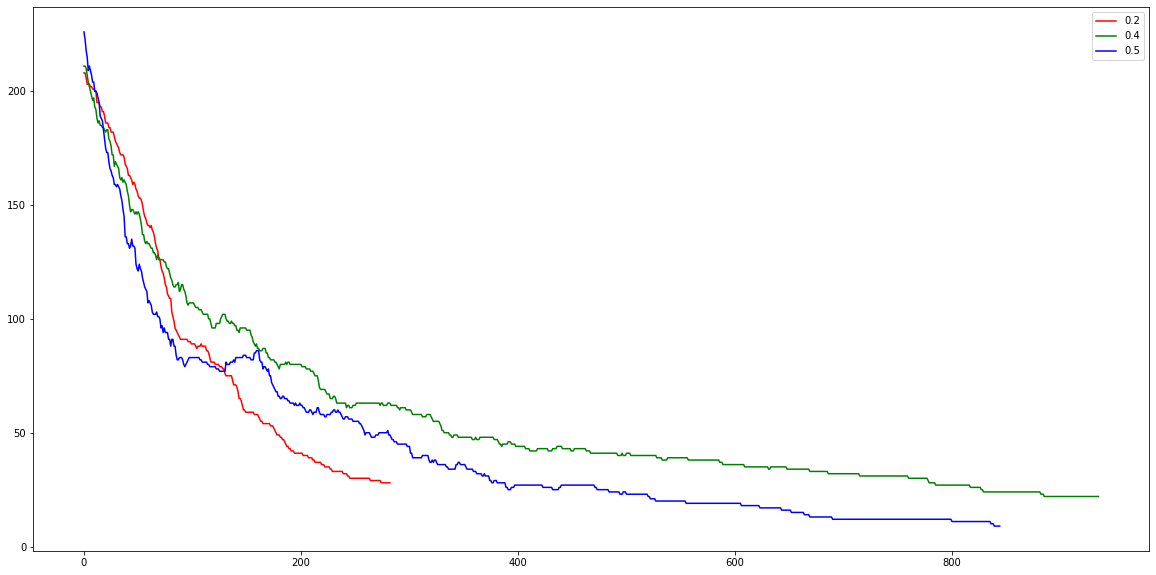

In [99]:
for p, c in zip(ps, colors):
    initial_val_generator(rows,columns, p)
    run_majority()
    grids = numpy_arrays_from_log(rows,columns)
    clusters =  [ get_clusters(grids[x]) for x in range(len(grids)) ] 
    plt.plot(clusters, label=str(p), color=c)
    plt.legend()

In [15]:
line_val_generator(rows,columns,0.7)

### Un ejemplo con una imagen real

Nos parecio interesante probar como se comporta el modelo cuando se tiene como entrada una imagen real. Curiosamente, aunque la proporcion inical de 1s es de alreredor de 75%, *el sistema no cambia mucho su composocopm original*. Esto quizas esta relacionado con como estan organizadas las imagenes naturales. Donde ya hay grandes clusters desde el principio.

(-0.5, 39.5, 39.5, -0.5)

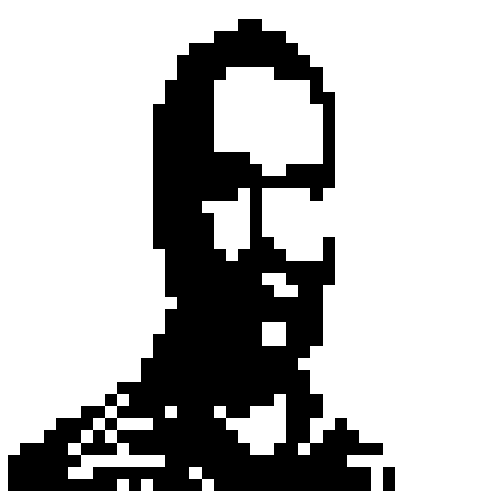

In [92]:
from matplotlib.pyplot import figure

figure(figsize=(8, 8), dpi=80)

im = from_image("images/Rodrigo-Castro.jpg", (columns,rows))
img_to_val("images/Rodrigo-Castro.jpg", (columns,rows))
plt.imshow(255-im, cmap="Greys")
plt.axis('off')

In [93]:
run_majority()

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from majority.ma
Loading events from 
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: logs/majority.log
Output to: /dev/null
Tolerance set to: 1e-08
Configuration to show real numbers: Width = 12 - Precision

At 00:00:00:419:0

Simulation complete!
Simulation ended!
LP 0 has finished simulation 


In [95]:
grids = numpy_arrays_from_log(rows,columns)


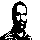

In [96]:
import base64
from IPython.core.display import HTML

imgs = [PIL.Image.fromarray(arr*255) for arr in grids]
imgs[0].save(fp="images/run.gif",format="GIF", append_images=imgs,  duration=37, save_all=True, loop=0)

b64 = base64.b64encode(open("images/run.gif",'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" width=350, height=350 />'))

Text(0, 0.5, 'fraccion de 1s')

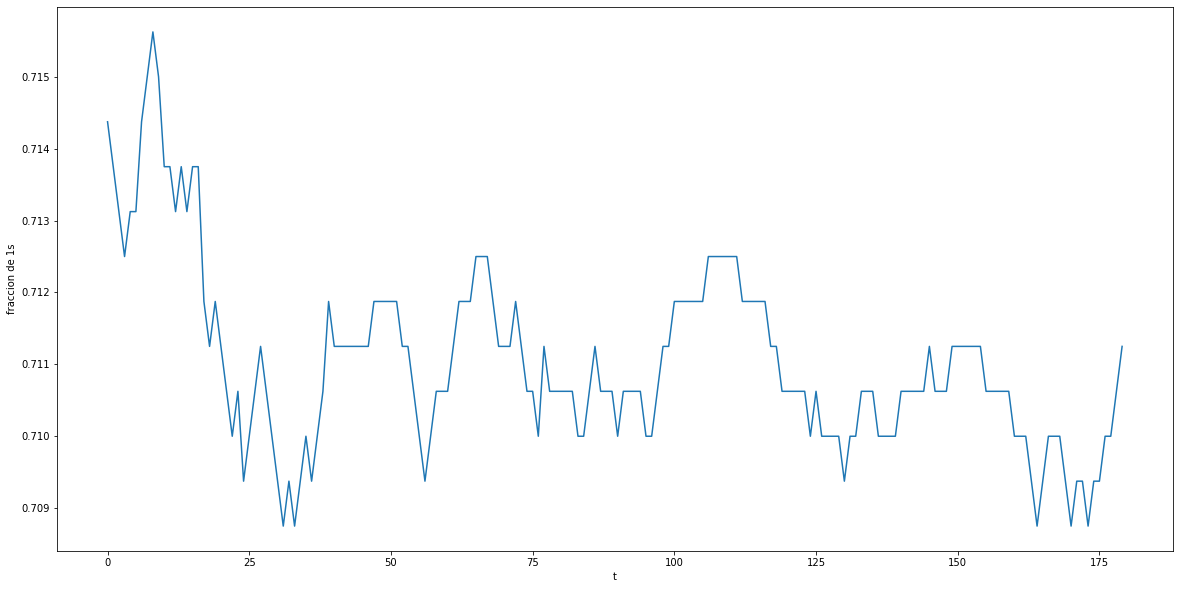

In [98]:
plt.plot(get_global_vote_series(grids))
plt.xlabel("t")
plt.ylabel("fraccion de 1s")

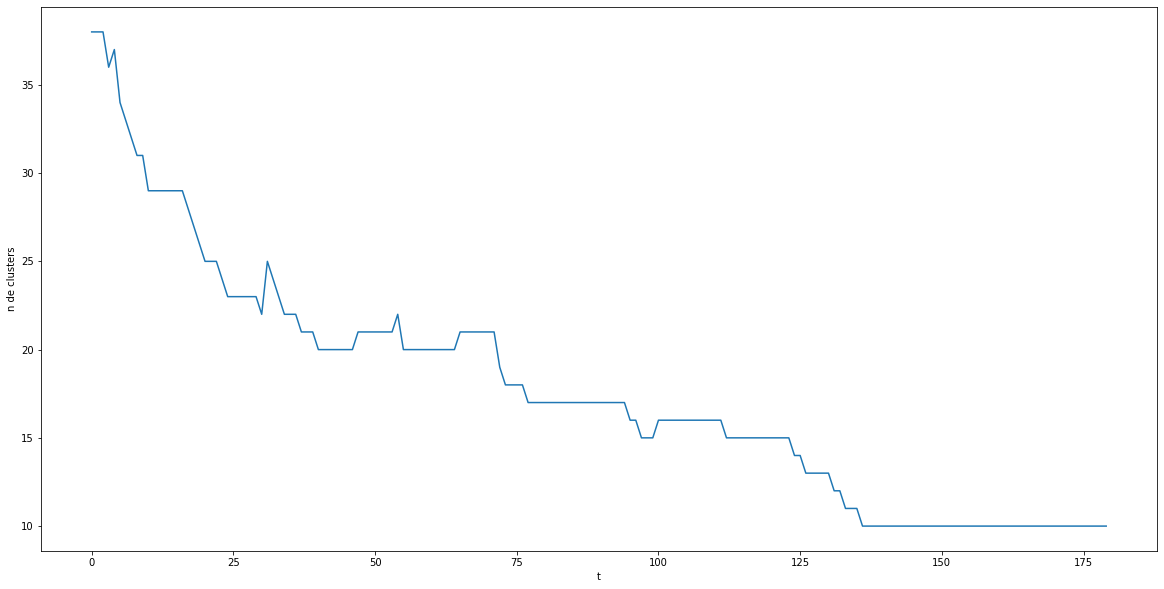

In [97]:
clusters =  [ get_clusters(grids[x]) for x in range(len(grids)) ] 
plt.xlabel("t")
plt.ylabel("n de clusters")
plt.plot(clusters)